In [1]:
import torch
import torch.nn as nn
import numpy as np
import librosa
import matplotlib.pyplot as plt
import IPython.display as ipd
from model_AAE import *
from model_unet import *
from utils import *
from dataloader import *
import librosa.display
from scipy.signal import savgol_filter
%matplotlib inline

In [2]:
def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return b, a


def butter_highpass_filter(data, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [3]:
x,sr = librosa.load('./datasets/EGG2.WAV',sr=48000,mono=False)
x = librosa.resample(x,sr,16000)

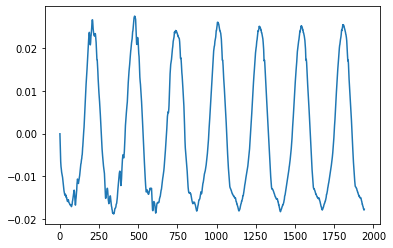

In [21]:
plt.plot(x[0][25114:27057])

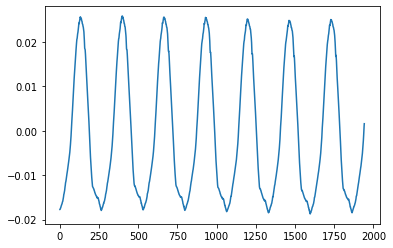

In [22]:
plt.plot(x[0][27057:29000])

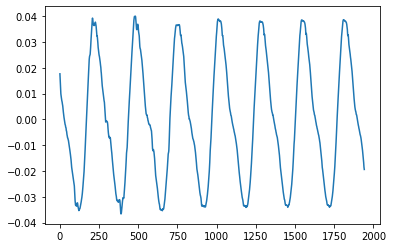

In [20]:
plt.plot(np.subtract(x[0][25114:27057],x[0][27057:29000]))

In [17]:
ipd.Audio(np.subtract(x[0][25114:27057],x[0][27057:29000]), rate=16000)

/opt/conda/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


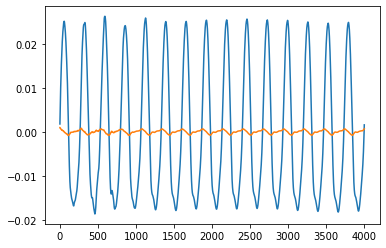

In [12]:
diff,idxs = get_peaks(x[0][25000:29000])

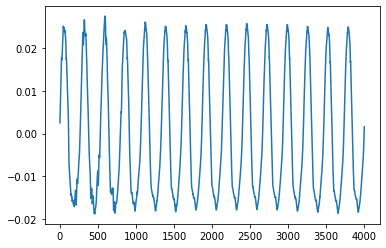

In [5]:
plt.plot(x[0][25000:29000])

In [22]:
diff,idxs =get_peaks(x[0][27000:29000])

/opt/conda/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


In [26]:
diff = []
for i in range(len(idxs)-1):
    diff.append(idxs[i+1]-idxs[i])

diff 

[134, 133, 134, 133, 134, 132, 134, 133, 134, 132, 135, 131, 135, 132]

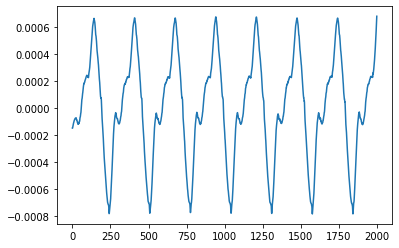

In [23]:
plt.plot(diff)

In [57]:
len(x)

2

In [8]:
def get_power(x):
    return np.mean(x*x)

In [9]:
def get_peaks(x):
    idxs = []
    x = savgol_filter(x,51,3)
    diff = [x[1]-x[0]]
    for i in range(len(x)-1):
        diff.append(x[i+1]-x[i])
    
    for i in range(len(diff)-1):
        if(diff[i]*diff[i+1] < 0):
            idxs.append(i)
    
    plt.plot(x)
    plt.plot(diff)
    return diff,idxs

In [10]:
def normalize(x):
    return -1 + 2*(x-np.min(x))/(np.max(x)-np.min(x))

In [11]:
def remove_noise(x,y):
    window = 512
    hop_length = 256
    
    step =0
    while(step*hop_length + window < len(y)):
#         print(step)
        if get_power(y[step*hop_length : step*hop_length + window]) < 1e-5 :
            m = x[step*hop_length : step*hop_length + window]
            break
        step+=1
    
    diff,idxs = get_peaks(m)

    frag = m[idxs[0]:idxs[1]]
    ns = idxs[1]-idxs[0]
    print(idxs)
    start_point = step*hop_length + idxs[0] 
    start_point = start_point%ns
    
    st = 0
    while((st+1)*ns < len(x)):
        x[st*ns : (st+1)*ns] = np.subtract(x[st*ns : (st+1)*ns], frag)
        st+=1
    return x,frag

[1, 26, 27, 28, 29, 30, 31, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 84, 85, 86, 87, 88, 89, 90, 91, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 194, 195, 196, 197, 198, 199, 200, 201, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 251, 252, 253, 254,

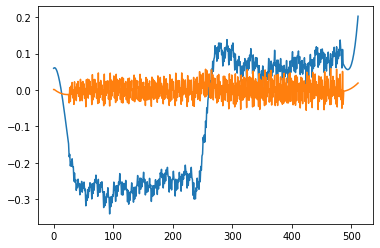

In [77]:
removed,frag = remove_noise(x[0],x[1])

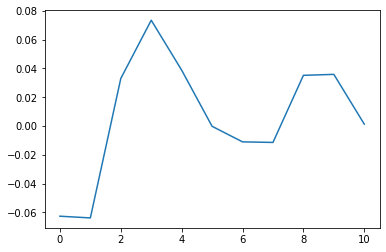

In [52]:
plt.plot(frag)

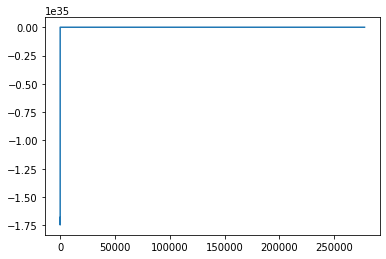

In [54]:
plt.plot(removed)

In [49]:
ipd.Audio(removed,rate=16000)

In [43]:
ipd.Audio(x[0][27000:29000],rate=16000)

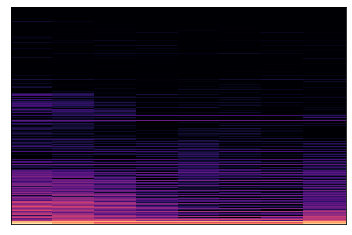

In [23]:
D = librosa.amplitude_to_db(np.abs(librosa.stft(x[0][25000:29000])), ref=np.max)
librosa.display.specshow(D)

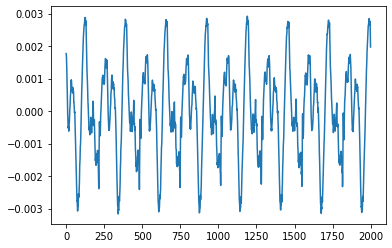

In [115]:
plt.plot(normalize(x[0][50000:55000]))

In [120]:
get_power(x[1][25000:27000])

0.0009490157

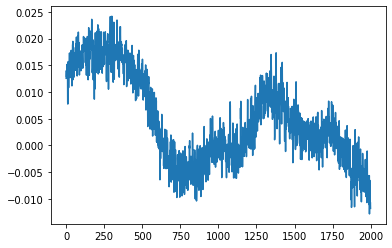

In [78]:
plt.plot(x[1][27000:29000])

NameError: name 'x' is not defined

In [2]:
# model = Resv2Unet(nlayers = 6, nefilters = 15)
# model = nn.DataParallel(model)
model = Unet(nlayers = 6,nefilters=12)
model.cuda()

Unet(
  (encoder): ModuleList(
    (0): Conv1d(1, 12, kernel_size=(15,), stride=(1,), padding=(7,))
    (1): Conv1d(12, 24, kernel_size=(15,), stride=(1,), padding=(7,))
    (2): Conv1d(24, 36, kernel_size=(15,), stride=(1,), padding=(7,))
    (3): Conv1d(36, 48, kernel_size=(15,), stride=(1,), padding=(7,))
    (4): Conv1d(48, 60, kernel_size=(15,), stride=(1,), padding=(7,))
    (5): Conv1d(60, 72, kernel_size=(15,), stride=(1,), padding=(7,))
  )
  (decoder): ModuleList(
    (0): Conv1d(144, 72, kernel_size=(5,), stride=(1,), padding=(2,))
    (1): Conv1d(132, 60, kernel_size=(5,), stride=(1,), padding=(2,))
    (2): Conv1d(108, 48, kernel_size=(5,), stride=(1,), padding=(2,))
    (3): Conv1d(84, 36, kernel_size=(5,), stride=(1,), padding=(2,))
    (4): Conv1d(60, 24, kernel_size=(5,), stride=(1,), padding=(2,))
    (5): Conv1d(36, 12, kernel_size=(5,), stride=(1,), padding=(2,))
  )
  (ebatch): ModuleList(
    (0): BatchNorm1d(12, eps=1e-05, momentum=0.1, affine=True, track_running

In [3]:
# model.load_state_dict(torch.load('./models/Resv2Unet/best_val.pth'))
model.load_state_dict(torch.load('./models/Unet/best_val_past.pth'))

In [53]:
n_frame = 576
n_shift = n_frame//3

def inference(model,x,n_frame = 576, n_shift_ratio = 3):
    model.eval()
    n_shift = n_frame//n_shift_ratio
    x_ = []
    result = np.zeros(shape = x.shape)
    step = 0
    x = butter_lowpass_filter(x,2500,16000)
    while(step*n_shift + n_frame <= len(x)):
        x_.append(normalize(x[step*n_shift:step*n_shift+n_frame]))
        step +=1
    x_ = np.array(x_)
    x_ = np.expand_dims(x_,axis=-1)
    x_ = torch.Tensor(x_).float().cuda()
    
    pred = model(x_)
    pred = pred.cpu().detach().numpy()
    pred = pred[:,:,0]
    for step in range(len(pred)):
        result[step*n_shift : step*n_shift + n_frame]+=pred[step]
    for step in range(len(pred)):
        k = min(step+1, n_shift_ratio, len(pred)-step)
        result[step*n_shift : (step+1)*n_shift]/= k
    
    return result

In [5]:
x, sr = librosa.load('./datasets/saarbrucken/export/1-iau.wav',sr = 50000)
x = librosa.resample(x,sr,16000)

y,sr = librosa.load('./datasets/saarbrucken/export/1-iau-egg.wav',sr = 50000)
y = librosa.resample(y,sr,16000)

In [44]:
x, sr = librosa.load('./datasets/cmu_us_bdl_arctic/orig/arctic_b0001.wav',sr=16000,mono=False)

x,y = x[0],x[1]

In [54]:
print(x.shape)
result = inference(model,x,n_frame = 576, n_shift_ratio = 3)

(27200,)
torch.Size([139, 576, 1])


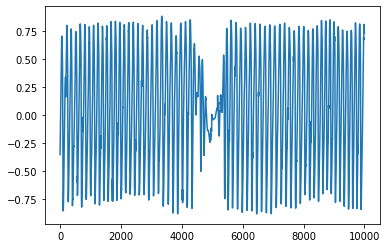

In [57]:
plt.plot(result[5000:15000])

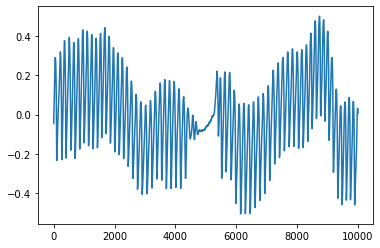

In [56]:
plt.plot(y[5000:15000])

In [63]:
from scipy.signal import savgol_filter

In [58]:
def DEGG(EGG):
    DEGG = np.zeros(EGG.shape)
    for i in range(len(EGG)-1):
        DEGG[i] = EGG[i+1]-EGG[i]
    return DEGG

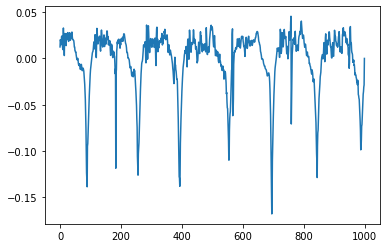

In [62]:
plt.plot(DEGG(result[5000:6000]))

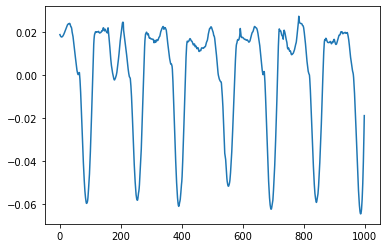

In [74]:
plt.plot(savgol_filter(DEGG(result[5000:6000]), 51, 3))

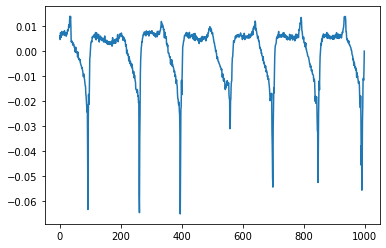

In [61]:
plt.plot(DEGG(y[5000:6000]))

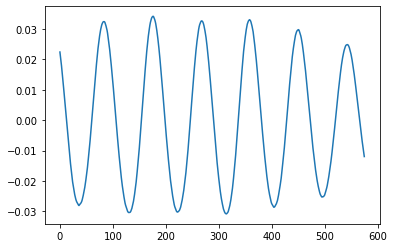

In [37]:
plt.plot(x[4000:4000+n_frame])

In [38]:
%%time

import torch.utils.data as data

x_ = x[4000:4000+n_frame]
x_ = butter_lowpass_filter(x_,2500,16000)
x_ = normalize(x_)
x_ = np.expand_dims(np.expand_dims(x_,axis=-1),axis=0)
x_ = torch.Tensor(x_).float().cuda()

model.eval()
pred = model(x_.float().cuda())

# result = inference(model,x[400000:400000+n_frame])
# plt.plot(result)

torch.Size([1, 576, 1])
CPU times: user 8.32 ms, sys: 104 ms, total: 112 ms
Wall time: 112 ms


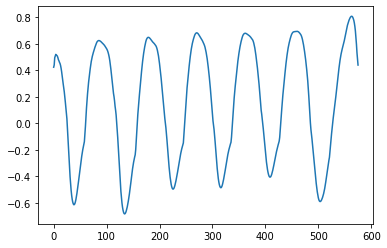

In [39]:
plt.plot(pred.cpu().detach().numpy()[0])

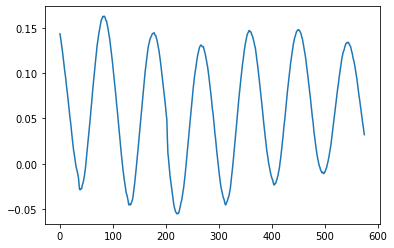

In [40]:
plt.plot(y[4000:4000+n_frame])